In [1]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydicom
import numpy as np
import warnings
import multiprocessing
import os
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import util
from skimage import transform

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['lines.linewidth'] = 2.5
# Get all data
tr = pd.read_csv('stage_1_train_labels.csv')
tr['aspect_ratio'] = (tr['width']/tr['height'])
tr['area'] = tr['width'] * tr['height']
def get_info(patientId, root_dir='stage_1_train_images/'):
    fn = os.path.join(root_dir, f'{patientId}.dcm')
    dcm_data = pydicom.read_file(fn)
    return {'age': dcm_data.PatientAge, 
            'gender': dcm_data.PatientSex, 
            'id': os.path.basename(fn).split('.')[0],
            'pixel_spacing': float(dcm_data.PixelSpacing[0]),
            'mean_black_pixels': np.mean(dcm_data.pixel_array == 0)}

In [ ]:
patient_ids = list(tr.patientId.unique())
with multiprocessing.Pool(4) as pool:
    result = pool.map(get_info, patient_ids)

In [3]:
demo = pd.DataFrame(result)
demo['gender'] = demo['gender'].astype('category')
demo['age'] = demo['age'].astype(int)

tr = (tr.merge(demo, left_on='patientId', right_on='id', how='left')
        .drop(columns='id'))

## What does the mostly white pixel images look like?

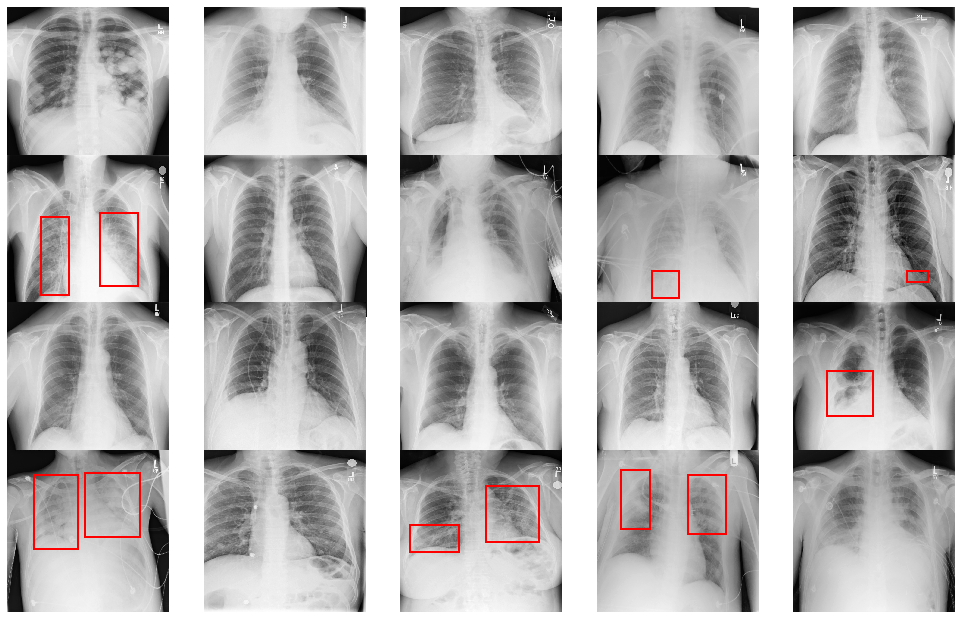

In [17]:
high_white_pixel_patientIds = tr.loc[tr.mean_black_pixels < 0.000001, 'patientId'].drop_duplicates()
fig, axes = plt.subplots(4, 5)
for patient_id, ax in zip(high_white_pixel_patientIds, axes.flatten()):
    row = tr.loc[tr.patientId == patient_id]
    img = get_image(row.patientId.iloc[0])
    bbs = row[['x', 'y', 'width', 'height']]
    draw_image(img, bbs, ax)
fig.tight_layout(pad=-1)

## What does the mostly black pixels look like?

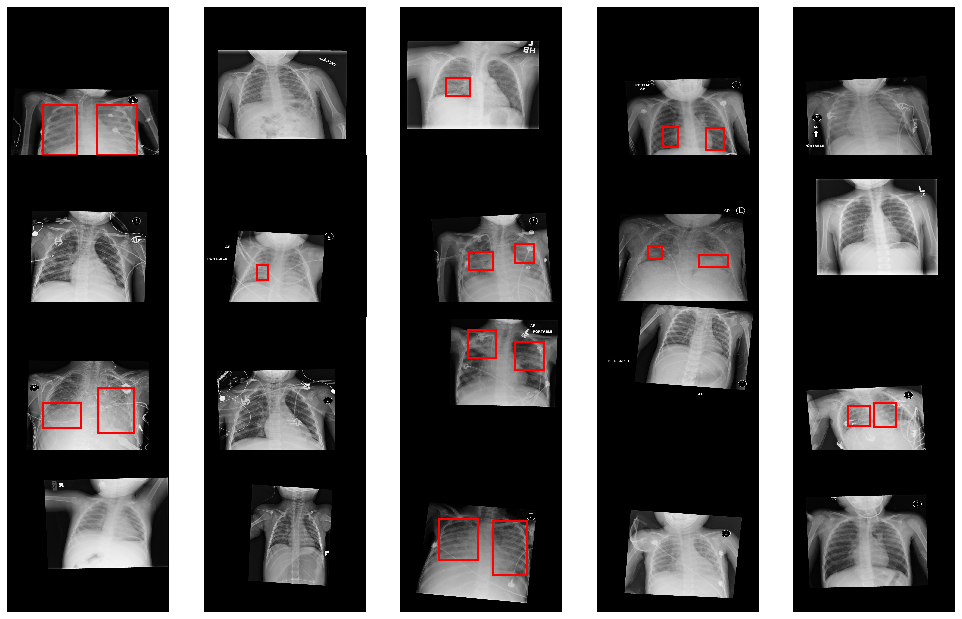

In [18]:
high_black_pixel_patientIds = tr.loc[tr.mean_black_pixels > 0.55, 'patientId'].drop_duplicates()
fig, axes = plt.subplots(4, 5)
for i, (patient_id, ax) in enumerate(zip(high_black_pixel_patientIds, axes.flatten())):
    row = tr.loc[tr.patientId == patient_id]
    img = get_image(row.patientId.iloc[0])
    bbs = row[['x', 'y', 'width', 'height']]
    draw_image(img, bbs, ax)
fig.tight_layout(pad=-1)

## Are the classes imbalanced? 

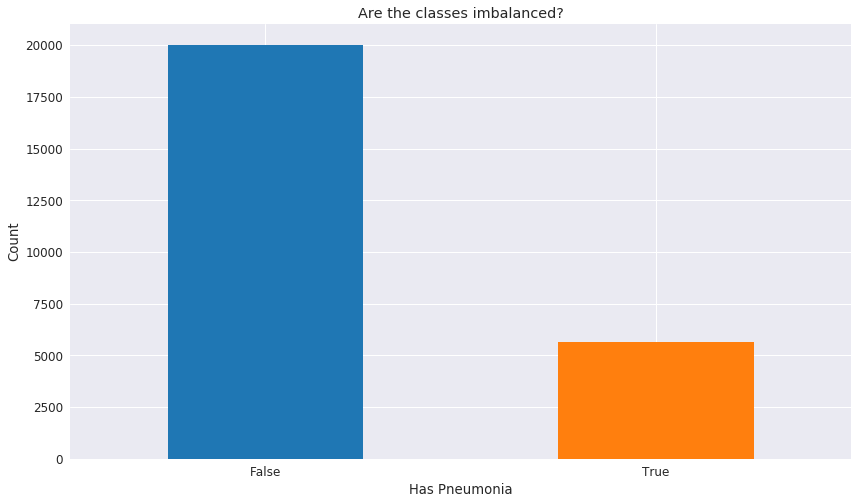

In [4]:
boxes_per_patient = tr.groupby('patientId')['Target'].sum()

ax = (boxes_per_patient > 0).value_counts().plot.bar()
_ = ax.set_title('Are the classes imbalanced?')
_ = ax.set_xlabel('Has Pneumonia')
_ = ax.set_ylabel('Count')
_ = ax.xaxis.set_tick_params(rotation=0)

## Where is Pneumonia located? 

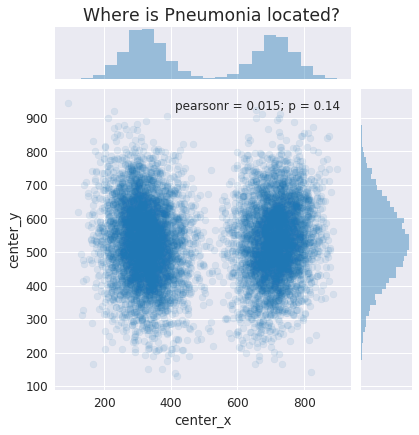

In [6]:
centers = (tr.dropna(subset=['x'])
           .assign(center_x=tr.x + tr.width / 2, center_y=tr.y + tr.height / 2))
ax = sns.jointplot("center_x", "center_y", data=centers, 
                   ##height=9, 
                   alpha=0.1)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)